# ME 595r - Autonomous Sytems
# Kalman Filter

## Dynamic Model
This filter will estimate the states of an autonomous underwater vehicle (AUV) moving forward along its longitudinal axis. Its dynamics are described by
$$ m\dot{v} + bv = F(t) $$
$$ \dot{x} = v $$

Where $v$ is the velocity of the vehicle, $x$ is its position, and F is a thrust input. Let the mass ($m$) be 100 kg and the linear drag coefficient ($b$) be 20 N-s/m.

Therefore the state vector will be defined as

$$ x = \begin{bmatrix}x \\ v\end{bmatrix} $$

and the dynamic model is given by

$$ \dot{x} = \begin{bmatrix}0 & 1 \\ 0 & -\tfrac{b}{m}\end{bmatrix}x + \begin{bmatrix}0 \\ \frac{1}{m}\end{bmatrix}u $$

## Measurements and Noise
We will directly measure the AUV position with a noise covariance of

$$ Q = 0.001 $$

and process noise covariance of

$$ R = \begin{bmatrix}0.0001 & 0 \\ 0 & 0.01 \end{bmatrix} $$

## Discretization
We will discretize the model using Taylor's Theorem to construch a first order approximation.

$$ A_d = (I + \Delta t A_c) $$
$$ B_d = (\Delta t B_c) $$
$$ C_d = C_c$$

Using a time step of $T_s = 0.05s$ gives the following discrete time model:

$$ x_{t} = \begin{bmatrix}1 & 0.05 \\ 0 & 0.99\end{bmatrix}x_{t-1} + \begin{bmatrix}0 \\ 0.0005 \end{bmatrix}u $$ 

## Implementation

In [2]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
#import plotly.plotly as pl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figWidth = 11
figHeight = 8

In [3]:
class DKF(object):
    def __init__(self, x0, A, B, C, R, Q, Sigma):
        self.A = A
        self.B = B
        self.C = C
        self.R = R
        self.Q = Q
        self.x = x0.reshape(2,1)
        self.Sigma = Sigma

    def predict(self,u):
#         print(u)
#         print(self.x)
#         print(A.dot(self.x).reshape(2,1))
#         print(self.B.dot(u))
        self.x = self.A.dot(self.x).reshape(2,1) + self.B.dot(u)
        self.Sigma = self.A.dot(self.Sigma.dot(self.A.T)) + self.R
        
    def update(self,z):
#         print(z)
        S = self.C.dot(self.Sigma.dot(self.C.T)) + self.Q
        #print(self.x.shape)
        #print(self.Sigma.dot(self.C.T).shape)
        self.K = self.Sigma.dot(self.C.T).dot(np.linalg.inv(S))
        self.x = self.x + self.K.dot(z - self.C.dot(self.x))
        self.Sigma = (np.eye(A.shape[0]) - self.K.dot(self.C)).dot(self.Sigma)

In [4]:
Ts = 0.05
Tend = 50

T = np.arange(start=Ts, stop=Tend+Ts, step = Ts)

A = np.array([[1, 0.05],[0, 1-0.01]])
B = np.array([[0],[0.0005]])
C = np.array([[1, 0]])

R = np.array([[0.0001, 0],[0, 0.01]]) # process noise
Q = np.array([[0.001]]) # measurement noise

u = np.zeros_like(T)
u[T < 5] = 50
u[T >= 25] = -50
u[T > 30] = 0

X = np.zeros((2,len(T)))


# generate the truth (which you can't handle)
for i in xrange(len(T)-1):
    #print(A.dot(X[:,i].reshape(2,1)))
    #print(B.dot(u[i]))
    X[:,i+1] = (A.dot(X[:,i].reshape(2,1)) + B.dot(u[i]) + Ts*np.random.multivariate_normal(np.zeros(2), R).reshape(2,1)).flatten()

z = X[0,:] + np.random.randn(len(T))*np.sqrt(Q)

xHat = np.zeros_like(X)
xHat[:,0] = np.array([0,0])
kf = DKF(xHat[:,0], A, B, C, R, Q, 10*R)

# store the error standard deviation with time stamps
sig = np.zeros((3, len(T)-1))
epsilon = Ts/5
K = np.zeros_like(X)

for i in xrange(len(T)-1):
    kf.predict(u[i])
#     sig[0, 2*i] = T[i]-epsilon
#     sig[1:, 2*i] = np.sqrt(np.diagonal(kf.Sigma)).flatten()
    kf.update(z[0,i])
    sig[0, i] = T[i]
    sig[1:, i] = np.sqrt(np.diagonal(kf.Sigma))
    xHat[:, i] = kf.x.flatten()
    K[:, i] = kf.K.flatten()

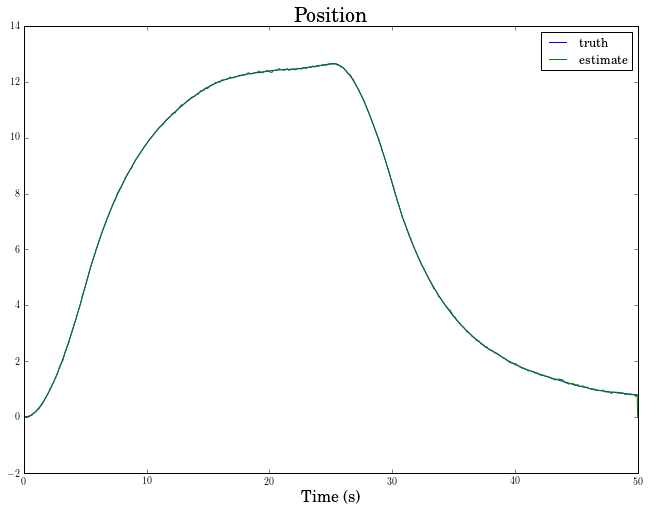

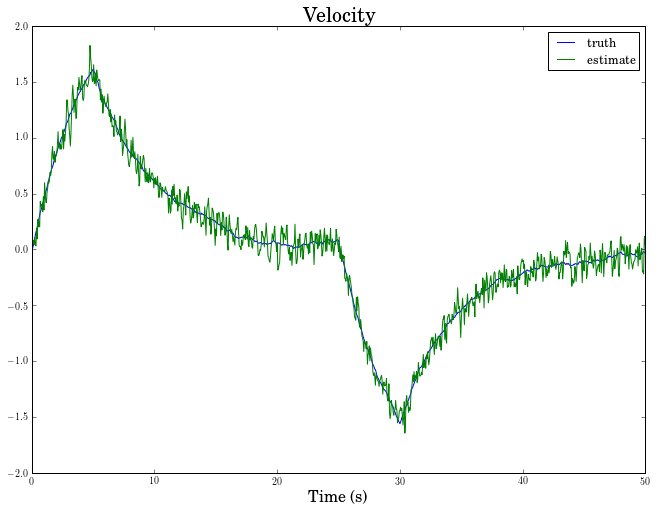

In [5]:
# data = [dict(
#         visible = True,
#         x = T,
#         y = X[0,:])]
    
# fig = dict(data=data)
# pl.iplot(fig, filename='jupyter/state')

plt.figure(figsize=(figWidth, figHeight))
plt.plot(T, X[0,:])
plt.plot(T, xHat[0,:])
plt.title("Position",fontsize=20)
plt.legend(["truth", "estimate"])
plt.xlabel("Time (s)", fontsize=16)
plt.show()
plt.figure(figsize=(figWidth, figHeight))
plt.plot(T, X[1,:])
plt.plot(T, xHat[1,:])
plt.title("Velocity",fontsize=20)
plt.legend(["truth", "estimate"])
plt.xlabel("Time (s)", fontsize=16)
plt.show()

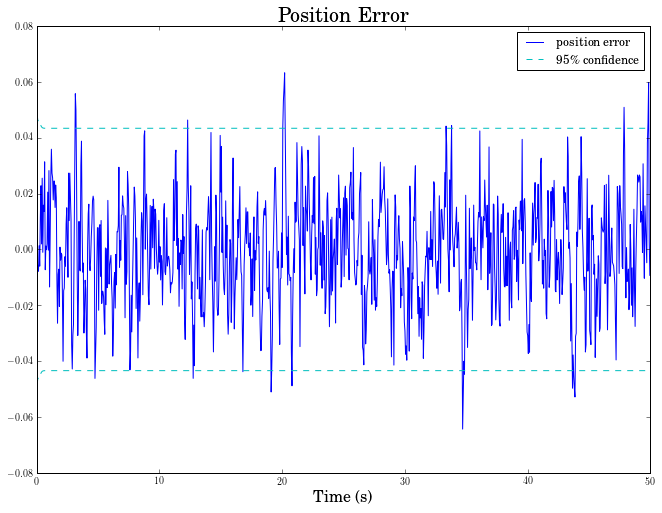

In [6]:
plt.figure(figsize=(figWidth, figHeight))
plt.plot(T[:-1], X[0, :-1] - xHat[0,:-1])
plt.plot(sig[0, :-1], 2*sig[1, :-1],'c--')
plt.plot(sig[0, :-1], -2*sig[1, :-1],'c--')
plt.title("Position Error",fontsize=20)
plt.legend(["position error", "95\% confidence"])
plt.xlabel("Time (s)", fontsize=16)
# plt.axis('tight')
plt.show()

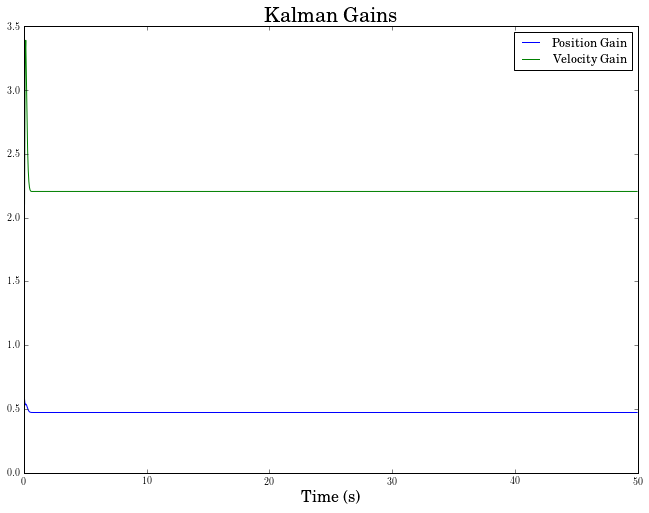

In [7]:
plt.figure(figsize=(figWidth, figHeight))
plt.plot(T[:-1], K[0, :-1])
plt.plot(T[:-1], K[1, :-1])
plt.title("Kalman Gains",fontsize=20)
plt.legend(["Position Gain", "Velocity Gain"])
plt.xlabel("Time (s)", fontsize=16)
# plt.axis('tight')
plt.show()

## Questions

* Q: How does the the system behave with poor initial conditions?
* A: The system converges within a second or two, even with very poor initial conditions. Also, an error in initial position guess induces an error in the velocity estimate.

* Q: How does the system behave with changes in process/noise convariances?
* A: Increasing measurement noise increases estimation error and increasing process noise increases noise in truth, but marginally decreases estimation error

* Q: How does the covariance change between the prediction and measurement update?
* A: Sigma increases after prediction and decreases after update.

* Q: How does measurement noise affect the Kalman gains?
* A: The Kalman gains are lower with higher measurement noise and vice versa.

# Solution Dataset

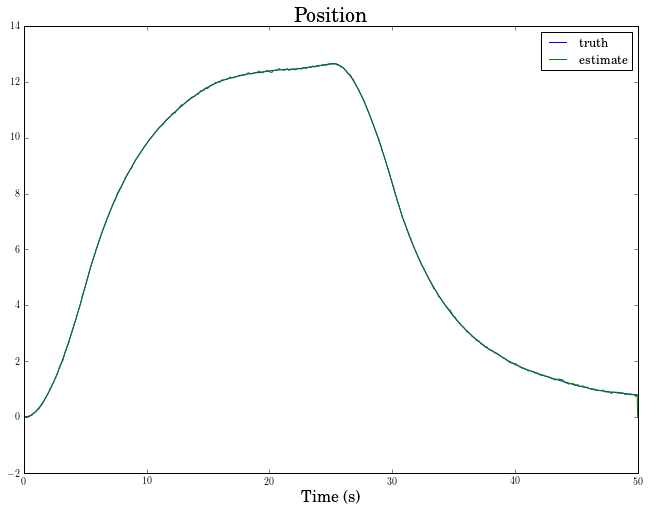

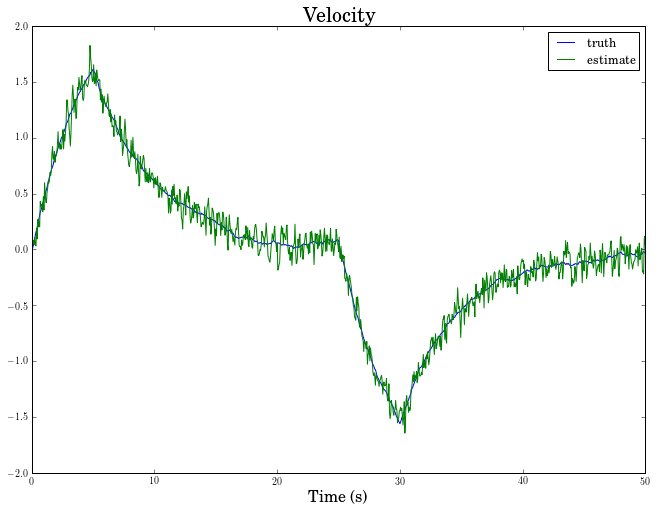

In [8]:
import scipy.io as sio

data = sio.loadmat('hw1_soln_data.mat')
x = np.vstack((np.array(data['xtr']), np.array(data['xtr'])))

xHat = np.zeros_like(X)
xHat[:,0] = np.array([0,0])
kf = DKF(xHat[:,0], A, B, C, R, Q, 10*R)

# store the error standard deviation with time stamps
sig = np.zeros((3, len(T)-1))
epsilon = Ts/5
K = np.zeros_like(X)

for i in xrange(len(T)-1):
    kf.predict(u[i])
#     sig[0, 2*i] = T[i]-epsilon
#     sig[1:, 2*i] = np.sqrt(np.diagonal(kf.Sigma)).flatten()
    kf.update(z[0,i])
    sig[0, i] = T[i]
    sig[1:, i] = np.sqrt(np.diagonal(kf.Sigma))
    xHat[:, i] = kf.x.flatten()
    K[:, i] = kf.K.flatten()
    
plt.figure(figsize=(figWidth, figHeight))
plt.plot(T, X[0,:])
plt.plot(T, xHat[0,:])
plt.title("Position",fontsize=20)
plt.legend(["truth", "estimate"])
plt.xlabel("Time (s)", fontsize=16)
plt.show()
plt.figure(figsize=(figWidth, figHeight))
plt.plot(T, X[1,:])
plt.plot(T, xHat[1,:])
plt.title("Velocity",fontsize=20)
plt.legend(["truth", "estimate"])
plt.xlabel("Time (s)", fontsize=16)
plt.show()